


# Tanh analysis part 1 



Given data $\mathbf{x} \in \mathbb{R}^{M}$, a random basis $\mathbf{B} \in \mathbb{R}^{D \times M}$ with $B_{i j} \sim \mathcal{N}(0, \sigma)$ we define our encoding as $\varphi: \mathbb{R}^{M} \rightarrow \mathbb{R}^{D}$ defined as
$$\varphi(\mathbf{x}) = \tanh (\mathbf{B} \mathbf{x})  $$
We want to recover $\mathbf{x}$ given $\varphi(\mathbf{x}) = \mathbf{h}$

## Utilities

This section defines various utilities that will be used in the code, such as loading utilities and constants.

In [ ]:
import numpy as np
import sklearn.datasets
from tqdm.notebook import tqdm
import torch
import random:
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
import numpy as np

#Constants
EPSILON = .0001

# load a dummy dataset
def load(data="mnist_784"):
  if data == "iris":
    (x, y) = sklearn.datasets.load_iris(return_X_y=True)
  else:
    (x, y) = sklearn.datasets.fetch_openml(data, return_X_y=True)
  scaler = sklearn.preprocessing.StandardScaler().fit(x)
  x = scaler.transform(x)
  return (x, y)

def discrete_gaussian(*dims):
  x = np.random.randn(*dims)
  x = np.round(x)
  return x

def rand_bipolar(*dims):
  x = np.random.randint(0, 2, size=dims, dtype=np.bool)
  x = np.where(x, 1.0, -1.0)
  return x

def newbasis(n_features, dimension,sigma=1):
  B= np.random.default_rng().normal(0,sigma, (dimension,n_features))
  return B

def encode_tanh(x, B):
  z = x @ B.T
  return np.tanh(z, dtype = 'float128')

def linear_encode(x,B):
  return x @ B.T

def plot_reconstruction(x, x_rec):
  n_features = x.shape[0]
  mse = np.mean((x - x_rec)**2)
  if n_features == 784:  # mnist
    x = np.reshape(x, [28, 28])
    x_rec = np.reshape(x_rec, [28, 28])
  else:
    x = np.tile(x, [n_features//2, 1])
    x_rec = np.tile(x_rec, [n_features//2, 1])

  plt.suptitle("Reconstruction. MSE = {:.4f}".format(mse))
  plt.subplot(1, 2, 1)
  plt.title("original")
  plt.imshow(x)
  plt.subplot(1, 2, 2)
  plt.title("reconstruction")
  plt.imshow(x_rec)

def decode_linear(z, B):
  xstar = np.linalg.lstsq(B, z.T, rcond=None)[0].T
  return xstar

def plot_hystograms(sample, B,li):
  fig = plt.figure(figsize=(8, 6), dpi=80)
  ax1 = fig.add_subplot(221)
  ax2 = fig.add_subplot(222)
  ax1.title.set_text('Original data')
  ax2.title.set_text('Data proyected')
  ax1.hist(sample)
  ax2.hist(li)
  ax2.axvline(20, color = 'red')
  ax2.axvline(-20, color = 'red')
  plt.show()


def psnr(img1, img2, max_value=255):
  mse = np.mean(( img1 - img2) ** 2)
  if mse == 0:
    return 100

  return 20 * np.log10(max_value / (np.sqrt(mse)))


def simple_correction(h):
  eps = np.zeros(h.shape)
  eps[np.where(h ==1)] = -EPSILON
  eps[np.where(h == -1)] = EPSILON
  return  h + eps


def nonlinear_reconstruction(sample,dim,sigma=1,correction = True, quant = False):
  B = newbasis(sample.size, dim,sigma)
  h = np.float16(encode_tanh(sample,B) ) if quant else encode_tanh(sample,B)
  z = np.arctanh(simple_correction(h)) if correction else np.arctanh(h)
  reg = Ridge(solver='sag' )
  reg.fit(B,z.T)
  x_rec = reg.coef_ 
  return x_rec



def experiment1(sample, sigma =1, quant = False):
  dimtry = [i for i in range(500,20001,500)] #Dimensions to try 
  msediff = []
  for dim in dimtry:
    #make experiment
    x_rec = nonlinear_reconstruction(sample, dim, sigma,True,quant)
    mse = np.mean((sample - x_rec)**2)
    msediff.append(mse)

  plt.plot(dimtry,msediff)
  plt.suptitle("Dimensions vs MSE of reconstruction")
  plt.title("using simple correction")
  plt.ylabel("MSE of reconstruction")
  plt.xlabel("Dimension")
  plt.show()


def experiment2(sample, dim = 10000, quant = False):
  sigmas = np.arange(0.5,8.0,.5)
  errors = []
  for sig in sigmas:
    x_rec = nonlinear_reconstruction(sample, dim, sig, True, quant)
    mse = np.mean((sample - x_rec)**2)
    errors.append(mse)

  plt.plot(sigmas,errors)
  plt.suptitle("Sigma vs MSE of reconstruction")
  plt.title("Using simple reconstruction")
  plt.ylabel("MSE of reconstruction")
  plt.xlabel("Sigma")


def experiment3(sample,dim = 10000, quant = False):
  sigmas = np.arange(0.5,6.0,.5)
  corrected = []

  for sig in sigmas:
    Base= newbasis(sample.size, dim,sig)
    h = np.float16(encode_tanh(sample,Base) ) if quant else encode_tanh(sample,Base)
    zcorr = np.arctanh(simple_correction(h))
    regre = Ridge(solver='sag' )
    regre.fit(Base,zcorr.T)
    x_rec = regre.coef_
    corr = np.where(np.abs(h)==1)[0].size
    corrected.append(corr)

  plt.plot(sigmas,corrected)
  plt.suptitle("Sigma vs # corrected entries")
  plt.ylabel("# of corrected entries in h")
  plt.xlabel("Sigma")

def experiment4(sample,dimensions):
  sigmas = np.arange(0.5,8.0,.5)
  dimlabels = [ str(dim) for dim in dimensions]

  for i in range(0,4):
    plt.clf()
    errors = []
    dim = dimensions[i]
    experiment2(sample,dim)
    for sig in sigmas:
      x_rec = nonlinear_reconstruction(sample, dim, sig, True)
      mse = np.mean((sample - x_rec)**2)
      errors.append(mse)

    plt.plot(sigmas,errors)
    plt.suptitle("Sigma vs MSE of reconstruction")
    plt.title("Dimension: "+ dimlabels[i])
    plt.ylabel("MSE of reconstruction")
    plt.xlabel("Sigma")
    plt.show





In [ ]:
import numpy as np
import sklearn.datasets
from tqdm.notebook import tqdm
import torch
import random:
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
import numpy as np

#Constants
EPSILON = .0001

# load a dummy dataset
def load(data="mnist_784"):
  if data == "iris":
    (x, y) = sklearn.datasets.load_iris(return_X_y=True)
  else:
    (x, y) = sklearn.datasets.fetch_openml(data, return_X_y=True)
  scaler = sklearn.preprocessing.StandardScaler().fit(x)
  x = scaler.transform(x)
  return (x, y)

def discrete_gaussian(*dims):
  x = np.random.randn(*dims)
  x = np.round(x)
  return x

def rand_bipolar(*dims):
  x = np.random.randint(0, 2, size=dims, dtype=np.bool)
  x = np.where(x, 1.0, -1.0)
  return x

def newbasis(n_features, dimension,sigma=1):
  B= np.random.default_rng().normal(0,sigma, (dimension,n_features))
  return B

def encode_tanh(x, B):
  z = x @ B.T
  return np.tanh(z, dtype = 'float128')

def linear_encode(x,B):
  return x @ B.T

def plot_reconstruction(x, x_rec):
  n_features = x.shape[0]
  mse = np.mean((x - x_rec)**2)
  if n_features == 784:  # mnist
    x = np.reshape(x, [28, 28])
    x_rec = np.reshape(x_rec, [28, 28])
  else:
    x = np.tile(x, [n_features//2, 1])
    x_rec = np.tile(x_rec, [n_features//2, 1])

  plt.suptitle("Reconstruction. MSE = {:.4f}".format(mse))
  plt.subplot(1, 2, 1)
  plt.title("original")
  plt.imshow(x)
  plt.subplot(1, 2, 2)
  plt.title("reconstruction")
  plt.imshow(x_rec)

def decode_linear(z, B):
  xstar = np.linalg.lstsq(B, z.T, rcond=None)[0].T
  return xstar

def plot_hystograms(sample, B,li):
  fig = plt.figure(figsize=(8, 6), dpi=80)
  ax1 = fig.add_subplot(221)
  ax2 = fig.add_subplot(222)
  ax1.title.set_text('Original data')
  ax2.title.set_text('Data proyected')
  ax1.hist(sample)
  ax2.hist(li)
  ax2.axvline(20, color = 'red')
  ax2.axvline(-20, color = 'red')
  plt.show()


def psnr(img1, img2, max_value=255):
  mse = np.mean(( img1 - img2) ** 2)
  if mse == 0:
    return 100

  return 20 * np.log10(max_value / (np.sqrt(mse)))


def simple_correction(h):
  eps = np.zeros(h.shape)
  eps[np.where(h ==1)] = -EPSILON
  eps[np.where(h == -1)] = EPSILON
  return  h + eps


def nonlinear_reconstruction(sample,dim,sigma=1,correction = True, quant = False):
  B = newbasis(sample.size, dim,sigma)
  h = np.float16(encode_tanh(sample,B) ) if quant else encode_tanh(sample,B)
  z = np.arctanh(simple_correction(h)) if correction else np.arctanh(h)
  reg = Ridge(solver='sag' )
  reg.fit(B,z.T)
  x_rec = reg.coef_ 
  return x_rec



def experiment1(sample, sigma =1, quant = False):
  dimtry = [i for i in range(500,20001,500)] #Dimensions to try 
  msediff = []
  for dim in dimtry:
    #make experiment
    x_rec = nonlinear_reconstruction(sample, dim, sigma,True,quant)
    mse = np.mean((sample - x_rec)**2)
    msediff.append(mse)

  plt.plot(dimtry,msediff)
  plt.suptitle("Dimensions vs MSE of reconstruction")
  plt.title("using simple correction")
  plt.ylabel("MSE of reconstruction")
  plt.xlabel("Dimension")
  plt.show()


def experiment2(sample, dim = 10000, quant = False):
  sigmas = np.arange(0.5,8.0,.5)
  errors = []
  for sig in sigmas:
    x_rec = nonlinear_reconstruction(sample, dim, sig, True, quant)
    mse = np.mean((sample - x_rec)**2)
    errors.append(mse)

  plt.plot(sigmas,errors)
  plt.suptitle("Sigma vs MSE of reconstruction")
  plt.title("Using simple reconstruction")
  plt.ylabel("MSE of reconstruction")
  plt.xlabel("Sigma")


def experiment3(sample,dim = 10000, quant = False):
  sigmas = np.arange(0.5,6.0,.5)
  corrected = []

  for sig in sigmas:
    Base= newbasis(sample.size, dim,sig)
    h = np.float16(encode_tanh(sample,Base) ) if quant else encode_tanh(sample,Base)
    zcorr = np.arctanh(simple_correction(h))
    regre = Ridge(solver='sag' )
    regre.fit(Base,zcorr.T)
    x_rec = regre.coef_
    corr = np.where(np.abs(h)==1)[0].size
    corrected.append(corr)

  plt.plot(sigmas,corrected)
  plt.suptitle("Sigma vs # corrected entries")
  plt.ylabel("# of corrected entries in h")
  plt.xlabel("Sigma")

def experiment4(sample,dimensions):
  sigmas = np.arange(0.5,8.0,.5)
  dimlabels = [ str(dim) for dim in dimensions]

  for i in range(0,4):
    plt.clf()
    errors = []
    dim = dimensions[i]
    experiment2(sample,dim)
    for sig in sigmas:
      x_rec = nonlinear_reconstruction(sample, dim, sig, True)
      mse = np.mean((sample - x_rec)**2)
      errors.append(mse)

    plt.plot(sigmas,errors)
    plt.suptitle("Sigma vs MSE of reconstruction")
    plt.title("Dimension: "+ dimlabels[i])
    plt.ylabel("MSE of reconstruction")
    plt.xlabel("Sigma")
    plt.show





In [ ]:
plt.plot(sigmas,errors)
    plt.suptitle("Sigma vs MSE of reconstruction")
    plt.title("Dimension: "+ dimlabels[i])
    plt.ylabel("MSE of reconstruction")
    plt.xlabel("Sigma")
    plt.show

In [ ]:
#Loads dataset, in this case mnist 
(x,y) = load()
n_features = x.shape[1]
sample = x[1]

## Brief analysis
We take an arbitrary sample from the data set. In this part we make a brief analysis of the distribution of the data $\mathbf{x}$, the 
data projected to $\mathbb{R}^D$, $\mathbf{z} =\mathbf{Bx} $

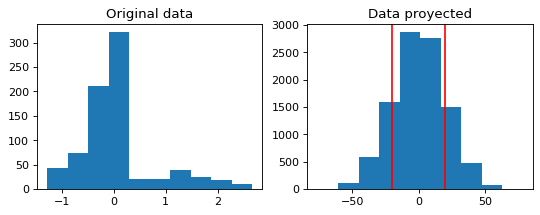

In [ ]:
SIGMA = 1
sample = x[1]

B= newbasis(n_features, 10000,SIGMA)
li = linear_encode(sample,B)
h = encode_tanh(sample,B)

plot_hystograms(sample,B,li)


In [ ]:
np.where(np.abs(h) == 1)[0].size 


2585

explanation of the graph 
### The problem

Having values equals to $ \pm 1 $ in $\mathbf{h}$ causes $\arctan$ to go to infinity. The number of entries that goes to $\pm 1$ in $\mathbf{h}$ increases as $\sigma$ increases.

#### the red line
In the case of float 128 it seems that for values in $\mathbf{z}$ which are bigger/smaller than $20$, the result of $\tanh$ goes to $\pm \infty$.

## One posible solution

We introduce a basic solution to our problem, named **simple correction**. Its an operation defined element wise

$$ C(h_i)  = \begin{cases}
h_i  - \epsilon \text{  if  } h_i = 1\\
h_i  + \epsilon \text{  if  } h_i = -1\\
h_i   \text{  if  } |h_i| \neq 1
\end{cases} \forall i \in [1,D]$$

We can apply $\tanh^{-1}$ to $\mathbb{h}$ after this correction method in order to get an aproximation $\tanh^{-1} (C ( \mathbf{h} ) )= \mathbf{z}^{*} \approx \mathbf{z}$.


### Results of using simple correction





PSNR: 51.191873134270836


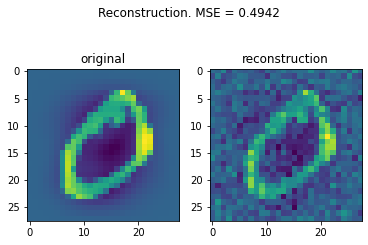

In [ ]:
x_rec = nonlinear_reconstruction(sample, 2000, 10,True)
plot_reconstruction(sample, x_rec)
print("PSNR: " + str(psnr(sample,x_rec)))

### Impact of dimension to the reconstruction

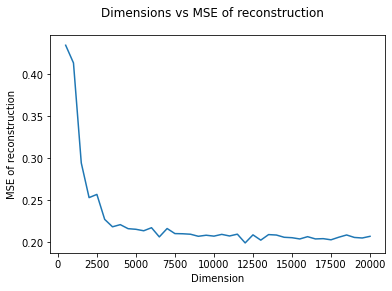

In [ ]:
# Sigma = 1
experiment1(sample, 1)

### Analysis of different values of sigma and its impact to the reconstruction


For this section we fix $D = 10000$

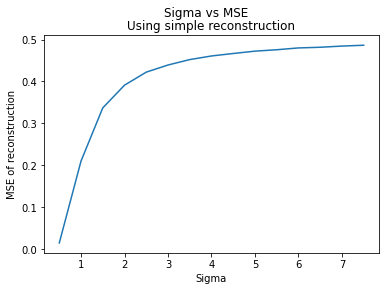

In [ ]:
#MSE vs sigma
experiment2(sample)

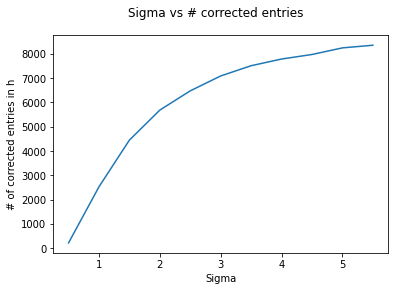

In [ ]:
# Entries corrected vs sigma
experiment3(sample, 10000)


### Trying different values of sigma with different dimension.

$D = 5000$

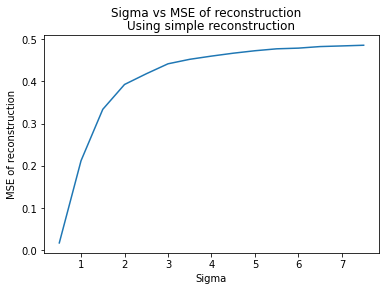

In [ ]:
experiment2(sample,5000)

$D = 10000$

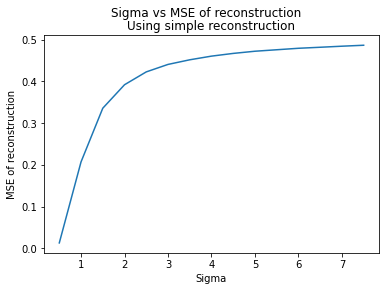

In [ ]:
experiment2(sample,10000)

$D = 15000$

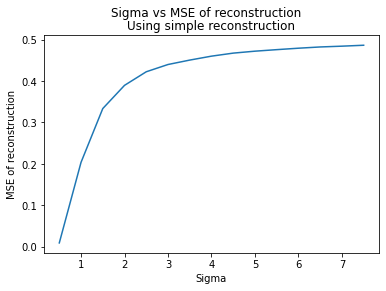

In [ ]:
experiment2(sample,15000)

$D = 20000$

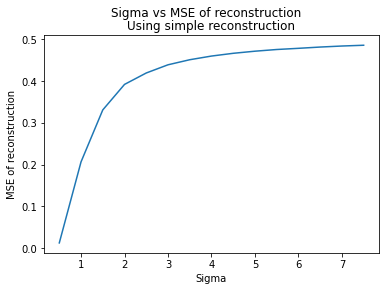

In [ ]:
experiment2(sample,20000)

## Quantization

We try quantization by going from float 128 to float 16 in order to protect the data

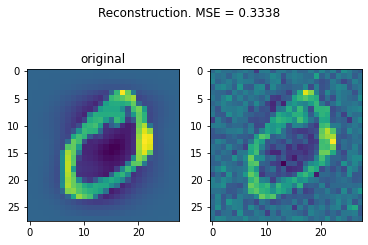

In [ ]:
# reconstruction after quantization with sigma = 1
x_rec = nonlinear_reconstruction(sample, 2000, 1,True,True)
plot_reconstruction(sample, x_rec)

51.027432708072325


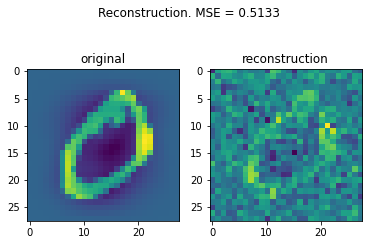

In [ ]:
# Dimension = 1000
# Sigma = 1000
x_rec = nonlinear_reconstruction(sample, 1000, 1000,True,True)
plot_reconstruction(sample, x_rec)
print(psnr(x_rec, sample))

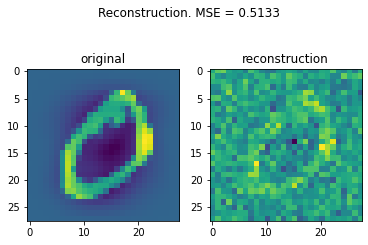

In [ ]:
# Dim = 500 and sigma = 1000
x_rec = nonlinear_reconstruction(sample, 500, 1000,True,True)
plot_reconstruction(sample, x_rec)

### Analysis of different values of sigma and its impact to the reconstruction (with quantization)

Again we fix $D = 10000$

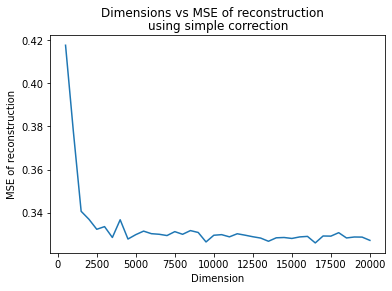

In [ ]:
experiment1(sample,1, True)

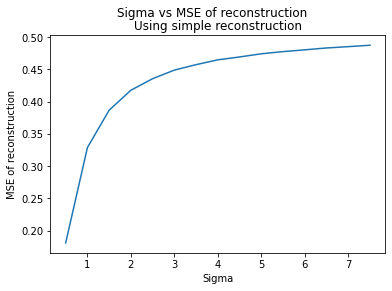

In [ ]:
experiment2(sample,10000, True)

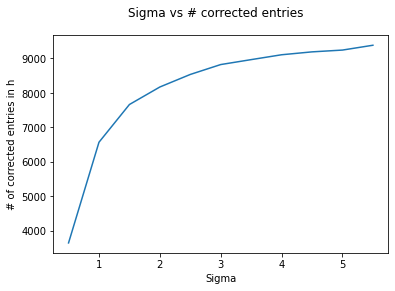

In [ ]:
experiment3(sample,10000, True)



## Tests with a bigger sample



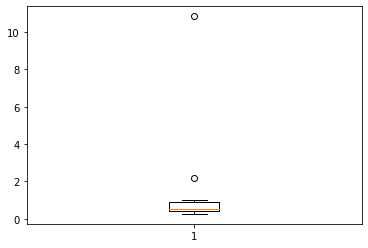

In [ ]:
indexes = random.choices(range(0,200) , k = 10)
bigsample = x[indexes]

errolist = []

for element in bigsample:
  x_rec = nonlinear_reconstruction(element, 10000, 10, True, True)
  mse = np.mean( (element - x_rec )**2) 
  errolist.append(mse)

plt.boxplot(errolist)
plt.show()

37.77828230085377


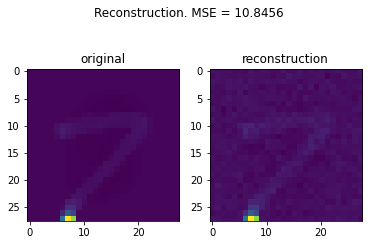

In [ ]:
i = np.argmax(errolist)
x_rec = nonlinear_reconstruction(bigsample[i], 10000, 10, True, True)
plot_reconstruction(bigsample[i], x_rec)
print( psnr(x_rec, bigsample[i]))

53.915946129132415


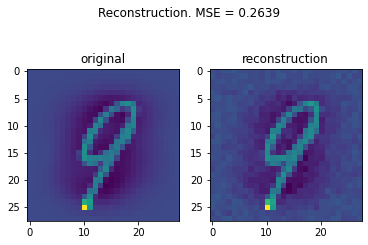

In [ ]:
i = np.argmin(errolist)
x_rec = nonlinear_reconstruction(bigsample[i], 10000, 10, True, True)
plot_reconstruction(bigsample[i], x_rec)
print( psnr(x_rec, bigsample[i]))

In [ ]:
SIGMA = 10
sample = x[1]

B= newbasis(n_features, 10000,SIGMA)
h = encode_tanh(sample,B)
hcorr = simple_correction(h)
np.linalg.norm(h -hcorr)

0.009565040512198574919